# Guía paso a paso: Construir un RAG con LangChain, OpenAI y Pinecone

Este notebook explica paso a paso cómo crear un RAG (Retrieval-Augmented Generation) usando OpenAI para incrustaciones y LLM, y Pinecone como base de datos vectorial.

### Conceptos

Se abordan los siguientes conceptos:

Indexación: un proceso para ingerir datos desde una fuente e indexarlos. Normalmente, esto ocurre en un proceso separado.

Recuperación y generación : el proceso RAG propiamente dicho, que toma la consulta del usuario en tiempo de ejecución y recupera los datos relevantes del índice, para luego pasarlos al modelo.



### Avance

En esta guía, se creará una aplicación que responda preguntas sobre el contenido de un sitio web. El sitio web específico que se utiliza es la publicación del blog «Agentes Autónomos Impulsados ​​por LLM» de Lilian Weng (https://lilianweng.github.io/posts/2023-06-23-agent/), permitiendo formular preguntas sobre su contenido.

## Configuración
### Instalación

Este tutorial requiere las siguientes dependencias de langchain:

In [27]:
%pip install langchain langchain-text-splitters langchain-community bs4

Note: you may need to restart the kernel to use updated packages.


## Componentes

Se necesita seleccionar tres componentes del conjunto de integraciones de LangChain.

Seleccionar un modelo de chat:

In [28]:
%pip install -U "langchain[openai]"

Note: you may need to restart the kernel to use updated packages.


In [29]:
import os
from langchain.chat_models import init_chat_model

try:
    from dotenv import load_dotenv
    load_dotenv()  # carga .env en os.environ si existe
except Exception:
    pass

if os.environ.get('OPENAI_API_KEY'):
    print('OPENAI_API_KEY cargada desde el entorno o desde .env (oculta).')
else:
    try:
        from getpass import getpass
        os.environ['OPENAI_API_KEY'] = getpass('OpenAI API key (se ocultará): ')
    except Exception:
        raise RuntimeError('No se encontró OPENAI_API_KEY en el entorno ni se pudo pedir interactivamente.')

model = init_chat_model('gpt-4.1')

OPENAI_API_KEY cargada desde el entorno o desde .env (oculta).


Seleccionar un modelo de incrustación:

In [30]:
%pip install -U "langchain-openai"

Note: you may need to restart the kernel to use updated packages.


In [31]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

Seleccionar una tienda de vectores:

In [32]:
%pip install -qU langchain langchain-pinecone langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [33]:
pip install "pinecone>=4.0.0"

Note: you may need to restart the kernel to use updated packages.


In [34]:
import getpass
import os

from pinecone import Pinecone

if not os.getenv("PINECONE_API_KEY"):
    os.environ["PINECONE_API_KEY"] = getpass.getpass("Enter your Pinecone API key: ")

pinecone_api_key = os.environ.get("PINECONE_API_KEY")

pc = Pinecone(api_key=pinecone_api_key)

Inicializar la base de datos:

In [35]:
from pinecone import ServerlessSpec

index_name = "langchain-test-index"  

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=3072,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )

index = pc.Index(index_name)

Desde la cuenta de pinecone se puede visualizar que se creó correctamente el índice:

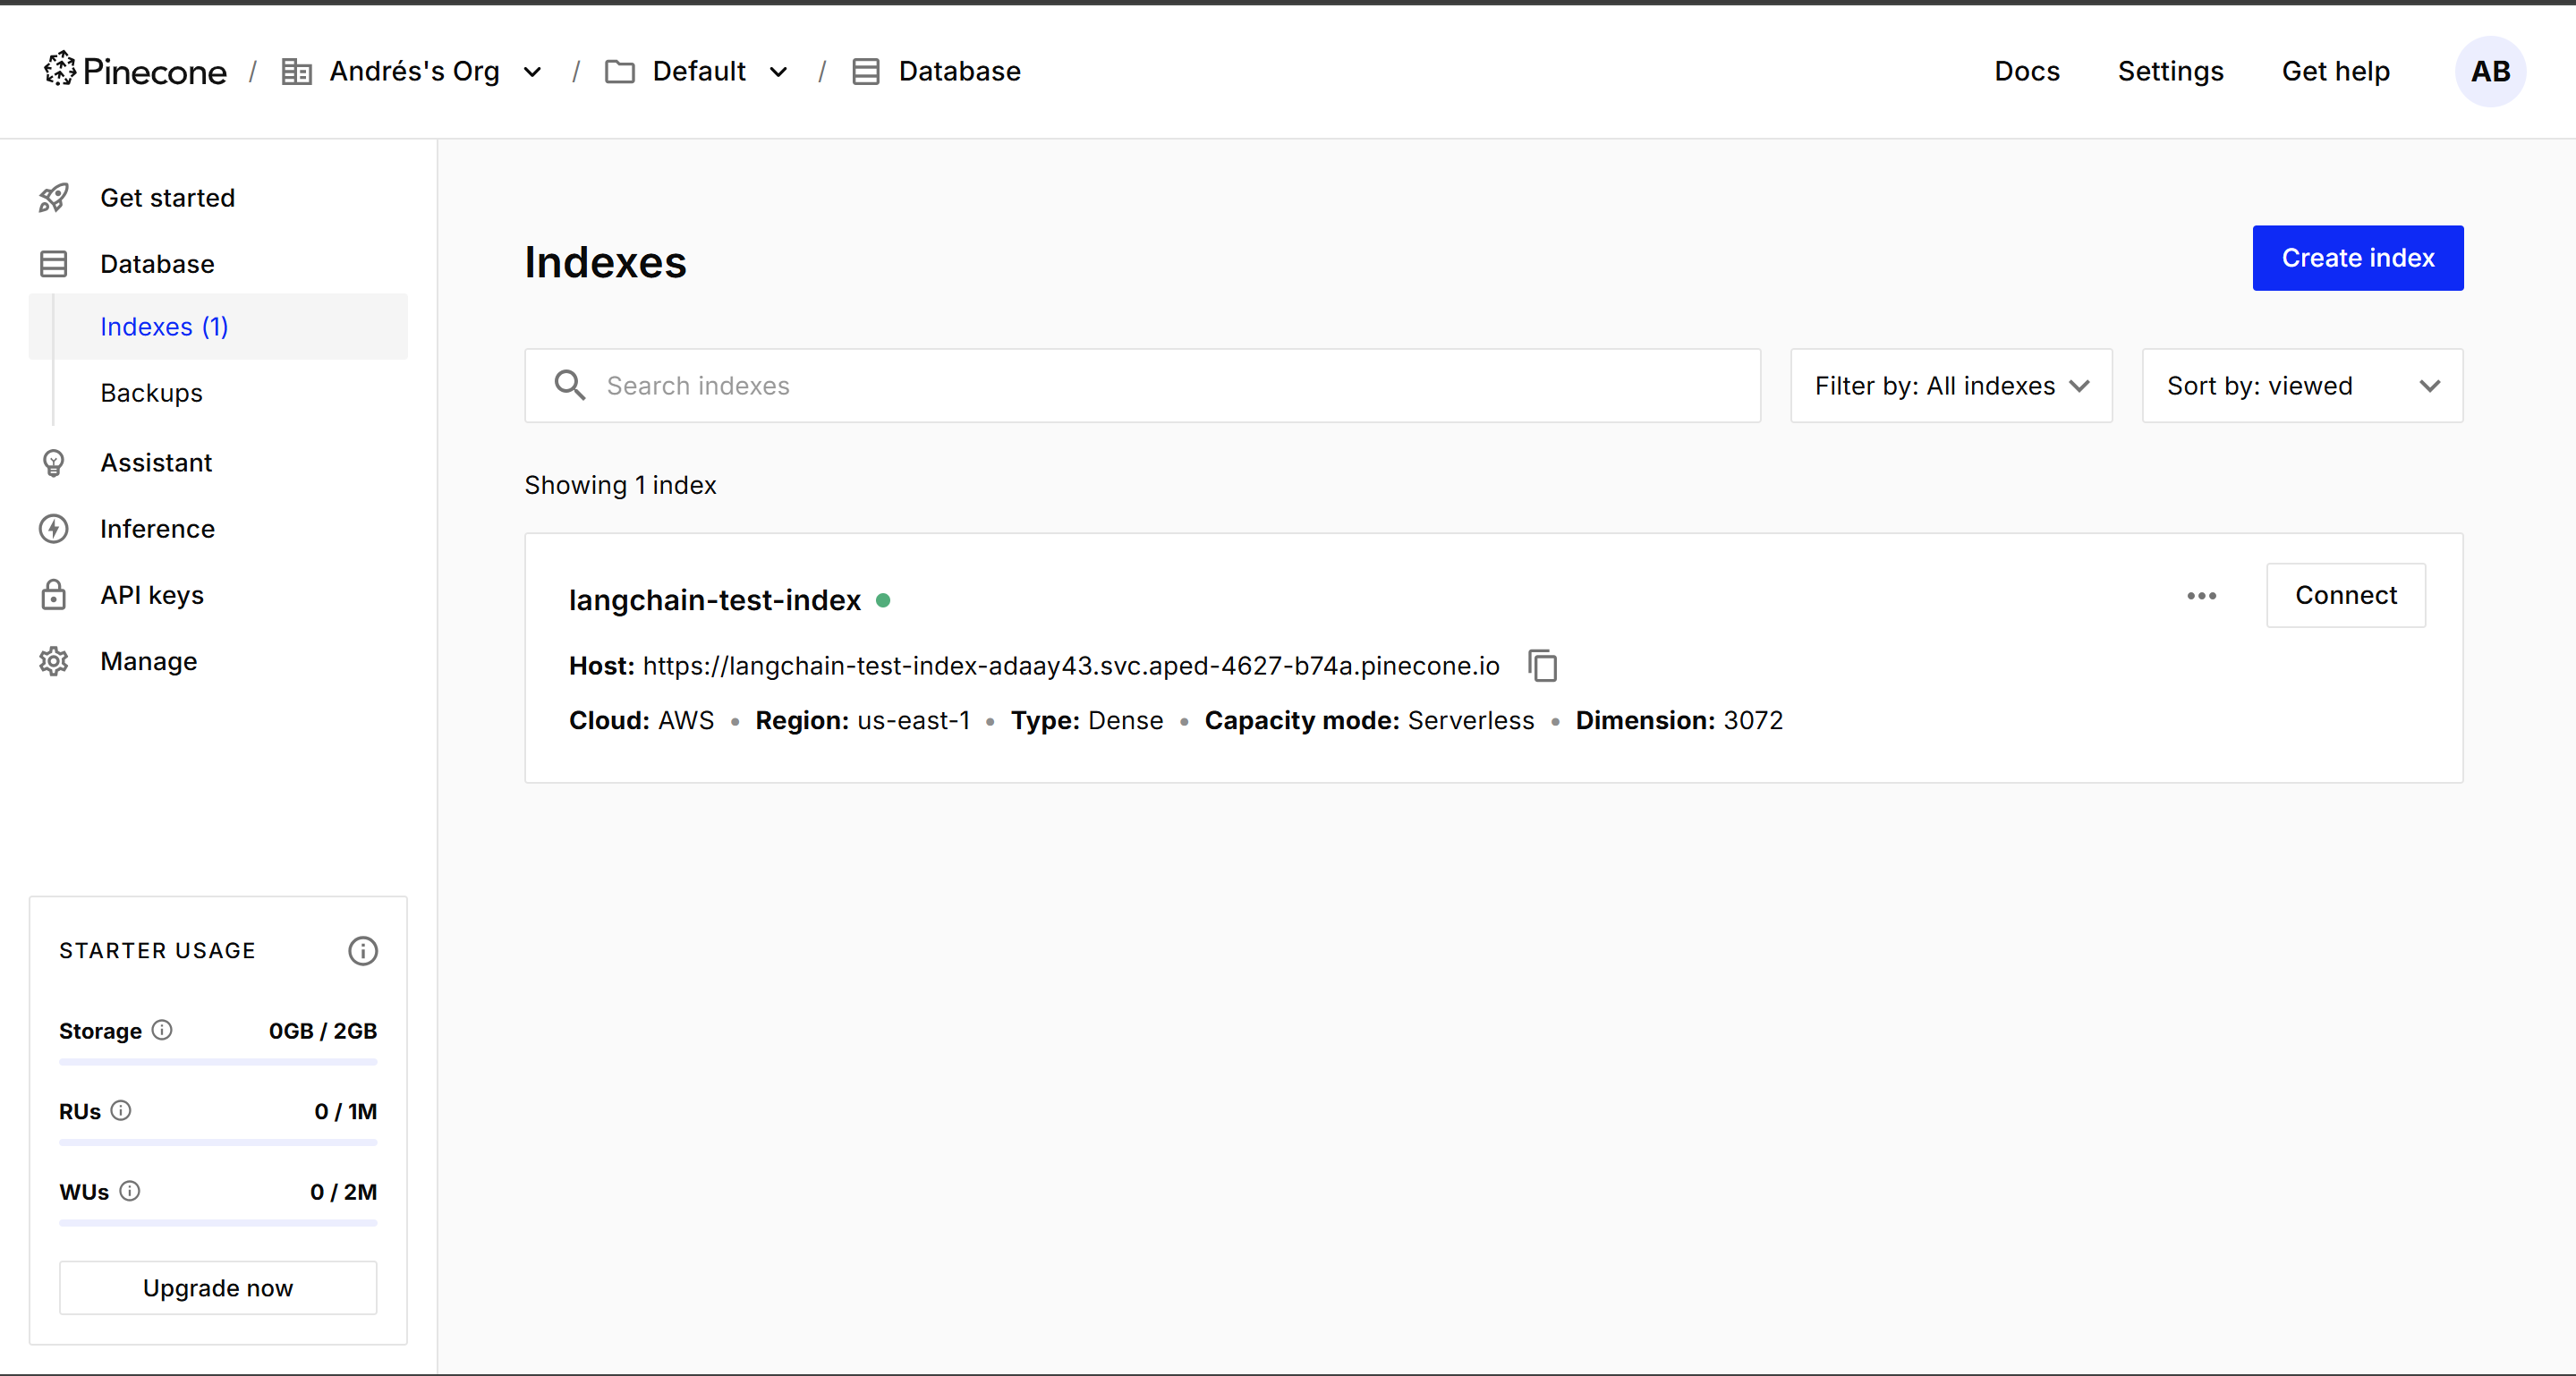

In [36]:
from langchain_pinecone import PineconeVectorStore

vector_store = PineconeVectorStore(
    index=index,          
    embedding=embeddings  
)

## 1. Indexación

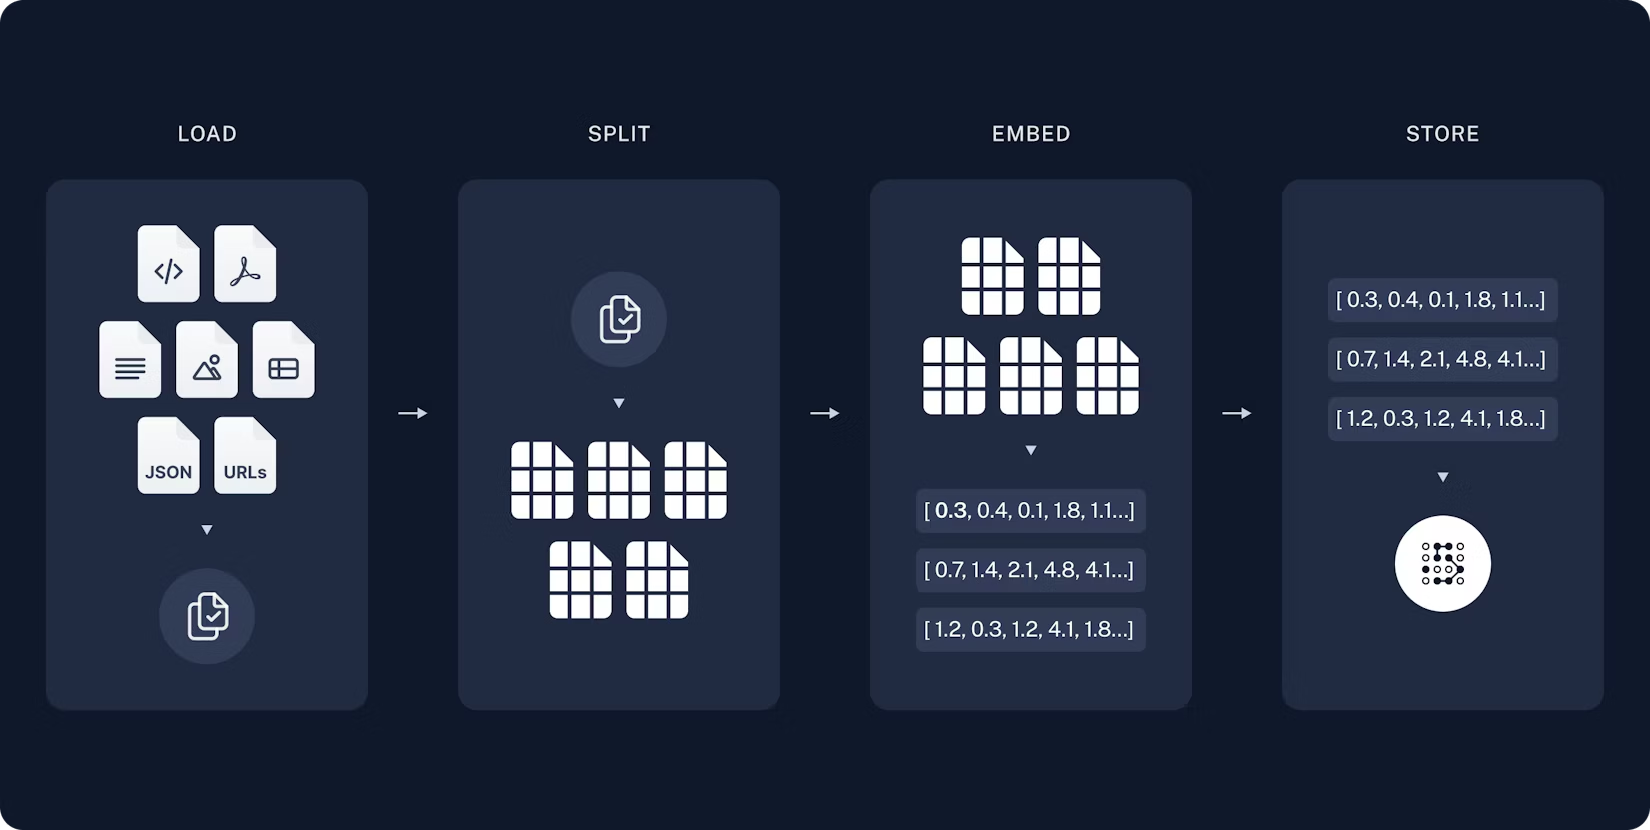

### Cargando documentos

In [37]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(class_=("post-title", "post-header", "post-content"))
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [38]:
print(docs[0].page_content[:500])



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


### Dividir documentos

In [39]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


### Almacenamiento de documentos en la base de datos vectorial

In [40]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['2c8ae456-c4e8-4746-a73d-1d88eb58380e', '48549687-0e69-4f54-8b12-c0d3697a99ff', '90d4f16c-f83c-4452-8625-a69ef04b106f']


Con esto se completa la fase de indexación del proceso. En este punto, se dispone de un almacén vectorial consultable que contiene el contenido fragmentado de la entrada de blog. Idealmente, ante una pregunta del usuario, se debería poder devolver los fragmentos de la entrada que responden a dicha pregunta.

## 2. Recuperación y generación

Las aplicaciones RAG suelen funcionar de la siguiente manera:

Recuperar : Dada una entrada del usuario, se recuperan las divisiones relevantes del almacenamiento utilizando un Retriever .

Generar : Un modelo produce una respuesta utilizando una solicitud que incluye tanto la pregunta como los datos recuperados.

### Agentes RAG

Una formulación de una aplicación RAG consiste en un agente simple con una herramienta que recupera información. Se puede crear un agente RAG mínimo implementando una herramienta que encapsule el almacén de vectores:

In [41]:
from langchain.tools import tool

@tool(response_format="content_and_artifact")
def retrieve_context(query: str):
    """Retrieve information to help answer a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\nContent: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Construir el agente:

In [42]:
from langchain.agents import create_agent


tools = [retrieve_context]
# If desired, specify custom instructions
prompt = (
    "You have access to a tool that retrieves context from a blog post. "
    "Use the tool to help answer user queries."
)
agent = create_agent(model, tools, system_prompt=prompt)

Poniendo esto a prueba:

 Formular una pregunta que normalmente requeriría una secuencia iterativa de pasos de recuperación para ser respondida:

In [43]:
query = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve_context (call_cNESWj1PrwM0mDXbpbadJzo7)
 Call ID: call_cNESWj1PrwM0mDXbpbadJzo7
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve_context

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578.0}
Content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.
Another quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external c

Tener en cuenta que el agente:

Genera una consulta para buscar un método estándar para la descomposición de tareas.

Al recibir la respuesta, genera una segunda consulta para buscar extensiones comunes de la misma.

Tras haber recibido todo el contexto necesario, responde a la pregunta.

## Cadenas RAG
En la formulación RAG agentiva, se permite que el LLM utilice su criterio para generar llamadas a herramientas que ayuden a responder las consultas de los usuarios. A continuación se resumen, en lenguaje sencillo, los puntos principales observados en la imagen:

**Beneficios**
- Búsqueda solo cuando sea necesaria: el LLM puede gestionar saludos, seguimientos y consultas sencillas sin generar búsquedas innecesarias.
- Consultas de búsqueda contextual: al tratar la búsqueda como una herramienta con una entrada `query`, el LLM crea sus propias consultas que incorporan el contexto conversacional.
- Se permiten múltiples búsquedas: el LLM puede ejecutar varias búsquedas en apoyo de una sola consulta de usuario.

**Desventajas**
- Dos llamadas de inferencia: cuando se realiza una búsqueda, suele haber una llamada para generar la consulta y otra para producir la respuesta final.
- Control reducido: el LLM puede omitir búsquedas cuando en realidad son necesarias, o realizar búsquedas adicionales cuando no lo son.

Estas ideas ayudan a comprender las compensaciones de usar agentes RAG: ganan flexibilidad y contexto, pero requieren cuidado para mantener control y eficiencia.

Otro enfoque común es una cadena de dos pasos, en la que siempre se ejecuta una búsqueda (potencialmente utilizando la consulta del usuario sin procesar) y se incorpora el resultado como contexto para una única consulta LLM. Esto da como resultado una única llamada de inferencia por consulta, lo que reduce la latencia a costa de la flexibilidad.

En este enfoque ya no se llama al modelo en un bucle, sino que se realiza una sola pasada.
Se puede implementar esta cadena eliminando las herramientas del agente e incorporando en su lugar el paso de recuperación en una solicitud personalizada:

In [44]:
from langchain.agents.middleware import dynamic_prompt, ModelRequest

@dynamic_prompt
def prompt_with_context(request: ModelRequest) -> str:
    """Inject context into state messages."""
    last_query = request.state["messages"][-1].text
    retrieved_docs = vector_store.similarity_search(last_query)

    docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)

    system_message = (
        "You are a helpful assistant. Use the following context in your response:"
        f"\n\n{docs_content}"
    )

    return system_message


agent = create_agent(model, tools=[], middleware=[prompt_with_context])

Probando:

In [45]:
query = "What is task decomposition?"
for step in agent.stream(
    {"messages": [{"role": "user", "content": query}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is task decomposition?
================================== Ai Message ==================================

**Task decomposition** is the process of breaking down a complex or complicated task into smaller, more manageable sub-tasks or steps. This approach makes it easier to understand, plan, and execute tasks that might otherwise be overwhelming.

In the context of language models (LLMs) and AI planning, task decomposition can be achieved in several ways:

1. **Simple prompting**: Guiding the AI to list steps or subgoals (e.g., "What are the subgoals for achieving XYZ?").
2. **Task-specific instructions**: Giving tailored prompts such as "Write a story outline" when writing a novel.
3. **Human input**: Having a person manually specify the sub-tasks.

There are also advanced methods:

- **Chain of Thought (CoT)**: The model is prompted to "think step by step," decomposing a complex task into a sequence 